# NBA Projections Documentation

Because there is no current active NBA season, all of our model performance evaluation is based off of cross validation.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sns.set_style("whitegrid")
import pickle

In [9]:
df = pd.read_csv("compare.csv")

In [10]:
X = df.drop(["home_win"], axis=1)
y = df.home_win.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# import trained model
model = pickle.load(open('model.pkl','rb'))

In [5]:
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)
probs = pd.DataFrame(y_probs,columns=['Loss','Win']).drop(columns=['Loss'])

<Figure size 864x720 with 0 Axes>

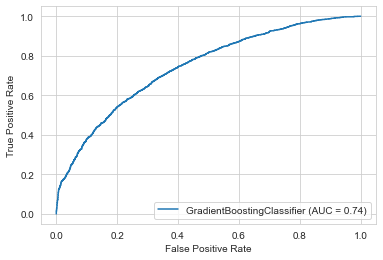

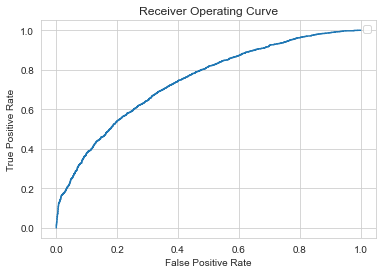

In [19]:
from sklearn.metrics import plot_roc_curve
_ = plt.figure(figsize=(12,10))
display = plot_roc_curve(model,X_test,y_test)
display.plot()
_ = plt.legend('')
_ = plt.savefig("roc.png")
_ = plt.title("Receiver Operating Curve")

In [18]:
from sklearn.metrics import roc_auc_score
clf = model
y_probs = clf.predict_proba(X_test)
probs = pd.DataFrame(y_probs,columns=['Loss','Win']).drop(columns=['Loss'])
roc_auc_score(y_test,probs)

0.7429441933330797

In [ ]:
y_pred = *************.predict_proba(X_test)
y_pred = pd.DataFrame(y_pred,columns=['Loss','Win']).drop(columns=['Loss'])
print("************* AUROC= " + str(round(roc_auc_score(y_test,y_pred),3)))

In [43]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
(tn, fp, fn, tp)

(704, 1576, 1075, 2339)

In [7]:
from sklearn.metrics import roc_curve, auc, accuracy_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("Model's AUROC= " + str(round(roc_auc,3)))

Model's AUROC= 0.64


In [30]:
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.68


In [29]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, probs)

(array([0.5936402 , 0.59356879, 0.59367311, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99704054e-01, 9.99704054e-01, ...,
        5.91891092e-04, 2.95945546e-04, 0.00000000e+00]),
 array([0.06290977, 0.0677507 , 0.07455351, ..., 0.96763831, 0.97163981,
        0.97351345]))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.68')

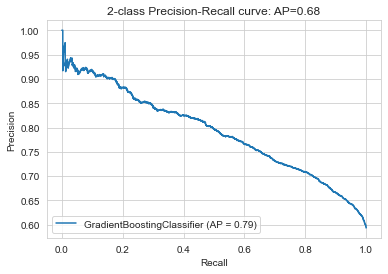

In [32]:
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [17]:
roc_curve(y_test,y_pred)

(array([0.        , 0.50712743, 1.        ]),
 array([0.        , 0.82036105, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6872146118721462

In [22]:
pred_probs

array([[0.39392908, 0.60607092],
       [0.17177563, 0.82822437],
       [0.25848858, 0.74151142],
       ...,
       [0.27039705, 0.72960295],
       [0.30589017, 0.69410983],
       [0.26635963, 0.73364037]])